In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.nn.functional as F
import os
import datetime
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score,f1_score
from sklearn.metrics import cohen_kappa_score


#Global Parameters and Variables loaded 
import config

if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

#empty cuda cache
torch.cuda.empty_cache()

# Models

In [2]:
print(config.channels)

class ContrastiveTripletModelwithPH(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModelwithPH, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer 
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  
        x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
    
class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

class ContrastiveTripletModelwithPHEfficient(nn.Module):
    def __init__(self, embedding_dim=1280, projection_dim=128, efficientnet_version='efficientnet_b0'):
        super(ContrastiveTripletModelwithPHEfficient, self).__init__()

        self.efficientnet = timm.create_model(efficientnet_version, pretrained=False, features_only=True)

        # Calculate the feature dimension of EfficientNet
        feature_dim = self.efficientnet.feature_info.channels()[-1]
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(feature_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        # Dropout layer 
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.efficientnet(x)[-1]  # Get the last set of features
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global Average Pooling and Flatten
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


# Set here the Model that should be fintuned

In [3]:
#Run1:
#Pretrain_model_dir = "./results/FIRST-2023-11-08-21-epochs-100-ADSMI"
#Run2:
#Pretrain_model_dir = "./results/CLR-2023-11-24-15-epochs-120-ADSMI-neu_V2"
#Run3:
Pretrain_model_dir = "./results/CLR-2023-12-08-16-epochs-250-ADSMI-neu_V5"

In [4]:



class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder

        # Fully connected layers for fine-tuning

        self.fc1 = nn.Linear(2048, 512)  # First FC layer
        self.fc2 = nn.Linear(512, 256)   # Second FC layer
        self.fc3 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))  # Apply ReLU after the first FC layer
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)
        return x


# class FineTuneModel(nn.Module):
#     def __init__(self, encoder, num_classes, dropout_probability=0.3):
#         super(FineTuneModel, self).__init__()
#         self.encoder = encoder

#         # Fully connected layers for fine-tuning
#         self.fc1 = nn.Linear(2048, 512)  # First FC layer
#         self.dropout1 = nn.Dropout(dropout_probability)  # Dropout layer after the first FC layer
#         self.fc2 = nn.Linear(512, 256)   # Second FC layer
#         self.dropout2 = nn.Dropout(dropout_probability)  # Dropout layer after the second FC layer
#         self.fc3 = nn.Linear(256, num_classes)  # Output layer

#     def forward(self, x):
#         x = self.encoder(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)  # Apply dropout after the first ReLU
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)  # Apply dropout after the second ReLU
#         x = self.fc3(x)
#         return x

class FineTuneModelFREEZE(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModelFREEZE, self).__init__()
        self.encoder = encoder

        # Freeze the encoder's parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Fully connected layers for fine-tuning
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

''''
class FineTuneModelFREZ(nn.Module):
    def __init__(self, pretrained_autoencoder, num_classes):
        super(FineTuneModelFREZ, self).__init__()
        # Use the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder

        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head: Three fully connected layers
        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes

        # dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x
'''

"'\nclass FineTuneModelFREZ(nn.Module):\n    def __init__(self, pretrained_autoencoder, num_classes):\n        super(FineTuneModelFREZ, self).__init__()\n        # Use the encoder from the pretrained autoencoder\n        self.encoder = pretrained_autoencoder.encoder\n\n        # Freeze the encoder\n        for param in self.encoder.parameters():\n            param.requires_grad = False\n\n        # Adaptive pooling layer\n        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))\n\n        # Classification head: Three fully connected layers\n        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer\n        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer\n        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes\n\n        # dropout for regularization\n        self.dropout = nn.Dropout(0.5)\n\n        # Non-linear activation function\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        # Pass inp

## Data


In [5]:
from Train_test_split_new import *

train_df, test_df, val_df = train_test_ADSMI()

foldername = "RS96_15sec_batch32_7_50_masking_ref5"
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64


### Model initalisation

In [6]:
# Hyperparameters
num_epochs = config.finetune_epochs 

weight_decay = 0  # L2 regularization
batch_size = config.batch_size
# Specify learning rates
learning_rate_encoder = 0.0003
learning_rate_fc = 0.0005
learning_rate = learning_rate_encoder


#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Early stopping parameters
patience = 20#config.patience 
early_stop_counter = 0


# Load the entire pre-trained model (from your contrastive training)
#pretrained_model = torch.load(Pretrain_model_dir + '/checkpoint.pth')
pretrained_model = torch.load(Pretrain_model_dir + '/checkpoint_17.pth')

# Load the pre-trained encoder
encoder_trained = pretrained_model.encoder

# Initialize the FineTuneModel with the pre-trained encoder
model = FineTuneModel(encoder_trained, num_classes).to(device)
#model = FineTuneModelFREEZE(encoder_trained, num_classes).to(device)



# Separate parameters of encoder and fully connected layers
encoder_params = model.encoder.parameters()
fc_params = list(model.fc1.parameters()) + list(model.fc2.parameters()) + list(model.fc3.parameters())

# Create parameter groups with different learning rates
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': learning_rate_encoder},
    {'params': fc_params, 'lr': learning_rate_fc}
])


# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4 ) 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) 

#Schedulers
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.6, verbose=True)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=5, mode='triangular')
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

#new folder path
finetune_results_dir = f'./finetune_results/FT_ADSMI_{foldername}'#{datetime.datetime.now().strftime("%Y-%m-%d-%H")}_V4lradj'

# Create a new folder to save the results
if not os.path.exists(finetune_results_dir):
    os.makedirs(finetune_results_dir)

# create log file
with open(f'{finetune_results_dir}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'Finetuning on CONTRASTIVE LOSS PRETRAIN{data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate_encoder}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')


train_losses = []
val_losses = []
best_accuracy = 0
best_f1_macro_avg = 0
best_loss = 1000
early_stop_counter = 0
save_counter = 0
save_start = 5
#model_path = "./finetune_results/newgpulr0001_checkpoint.pth"

In [7]:
#count parameters of pretrain model
pytorch_total_params = sum(p.numel() for p in pretrained_model.parameters())
print(pytorch_total_params)

30015656


In [8]:

from sklearn.metrics import f1_score as calculate_f1_score


for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    all_predicted = []
    all_labels = []
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy, loss, and now F1 score
    accuracy = correct_predictions / total_samples

    # Calculate macro avg f1 score using the alias
    f1_macro_avg = calculate_f1_score(all_labels, all_predicted, average='macro')

    if f1_macro_avg > best_f1_macro_avg and save_counter > save_start:
        best_f1_macro_avg = f1_macro_avg
        torch.save(model, finetune_results_dir + '/checkpoint_best_f1.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best F1 Score improved on epoch {epoch}: {best_f1_macro_avg:.4f}\n")

    if correct_predictions / total_samples > best_accuracy and save_counter > save_start:
        best_accuracy = accuracy
        torch.save(model, finetune_results_dir + '/checkpoint.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss and save_counter > save_start:
        best_loss = avg_val_loss
        torch.save(model, finetune_results_dir + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    save_counter += 1
    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%", f"Val F1 Score: {f1_macro_avg:.4f}")
    with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')

100%|██████████| 118/118 [00:45<00:00,  2.60it/s]


Epoch [1/120], Train Loss: 0.6922, Val Loss: 0.4642, Val Accuracy: 80.30% Val F1 Score: 0.7103


100%|██████████| 118/118 [00:28<00:00,  4.15it/s]


Epoch [2/120], Train Loss: 0.4528, Val Loss: 0.4170, Val Accuracy: 84.11% Val F1 Score: 0.8160


100%|██████████| 118/118 [00:29<00:00,  3.98it/s]


Epoch [3/120], Train Loss: 0.3983, Val Loss: 0.2956, Val Accuracy: 88.56% Val F1 Score: 0.8387


100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Epoch [4/120], Train Loss: 0.3726, Val Loss: 0.3650, Val Accuracy: 88.56% Val F1 Score: 0.8066


100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


Epoch [5/120], Train Loss: 0.3324, Val Loss: 0.2954, Val Accuracy: 90.89% Val F1 Score: 0.8482


100%|██████████| 118/118 [00:27<00:00,  4.22it/s]


Epoch [6/120], Train Loss: 0.3064, Val Loss: 0.3512, Val Accuracy: 88.77% Val F1 Score: 0.8342


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [7/120], Train Loss: 0.3412, Val Loss: 0.2416, Val Accuracy: 91.95% Val F1 Score: 0.8938


100%|██████████| 118/118 [00:28<00:00,  4.17it/s]


Epoch [8/120], Train Loss: 0.3066, Val Loss: 0.2243, Val Accuracy: 92.80% Val F1 Score: 0.8882


100%|██████████| 118/118 [00:28<00:00,  4.21it/s]


Epoch [9/120], Train Loss: 0.3141, Val Loss: 0.3388, Val Accuracy: 86.02% Val F1 Score: 0.8257


100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Epoch [10/120], Train Loss: 0.3265, Val Loss: 0.2452, Val Accuracy: 91.53% Val F1 Score: 0.8978


100%|██████████| 118/118 [00:28<00:00,  4.11it/s]


Epoch [11/120], Train Loss: 0.2947, Val Loss: 0.2483, Val Accuracy: 90.04% Val F1 Score: 0.8814


100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Epoch [12/120], Train Loss: 0.2888, Val Loss: 0.2241, Val Accuracy: 91.10% Val F1 Score: 0.8769


100%|██████████| 118/118 [00:27<00:00,  4.31it/s]


Epoch [13/120], Train Loss: 0.2754, Val Loss: 0.2699, Val Accuracy: 90.68% Val F1 Score: 0.8821


100%|██████████| 118/118 [00:27<00:00,  4.27it/s]


Epoch [14/120], Train Loss: 0.2833, Val Loss: 0.2737, Val Accuracy: 91.10% Val F1 Score: 0.8740


100%|██████████| 118/118 [00:27<00:00,  4.34it/s]


Epoch [15/120], Train Loss: 0.2651, Val Loss: 0.2043, Val Accuracy: 93.86% Val F1 Score: 0.9347


100%|██████████| 118/118 [00:27<00:00,  4.26it/s]


Epoch [16/120], Train Loss: 0.2616, Val Loss: 0.2453, Val Accuracy: 91.53% Val F1 Score: 0.8692


100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


Epoch [17/120], Train Loss: 0.2641, Val Loss: 0.2670, Val Accuracy: 91.53% Val F1 Score: 0.8742


100%|██████████| 118/118 [00:37<00:00,  3.17it/s]


Epoch [18/120], Train Loss: 0.2798, Val Loss: 0.2149, Val Accuracy: 92.58% Val F1 Score: 0.9175


100%|██████████| 118/118 [00:34<00:00,  3.41it/s]


Epoch [19/120], Train Loss: 0.2849, Val Loss: 0.2243, Val Accuracy: 93.22% Val F1 Score: 0.9104


100%|██████████| 118/118 [00:30<00:00,  3.93it/s]


Epoch [20/120], Train Loss: 0.2795, Val Loss: 0.2471, Val Accuracy: 92.16% Val F1 Score: 0.8668


100%|██████████| 118/118 [00:28<00:00,  4.13it/s]


Epoch [21/120], Train Loss: 0.2464, Val Loss: 0.2562, Val Accuracy: 92.37% Val F1 Score: 0.9010


100%|██████████| 118/118 [00:29<00:00,  4.03it/s]


Epoch [22/120], Train Loss: 0.2538, Val Loss: 0.2135, Val Accuracy: 94.49% Val F1 Score: 0.9244


100%|██████████| 118/118 [00:30<00:00,  3.84it/s]


Epoch [23/120], Train Loss: 0.2595, Val Loss: 0.2302, Val Accuracy: 91.74% Val F1 Score: 0.8885


100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


Epoch [24/120], Train Loss: 0.2461, Val Loss: 0.2643, Val Accuracy: 90.89% Val F1 Score: 0.8695


100%|██████████| 118/118 [00:29<00:00,  4.04it/s]


Epoch [25/120], Train Loss: 0.2390, Val Loss: 0.2884, Val Accuracy: 91.10% Val F1 Score: 0.8970


100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Epoch 00026: reducing learning rate of group 0 to 1.8000e-04.
Epoch 00026: reducing learning rate of group 1 to 3.0000e-04.
Epoch [26/120], Train Loss: 0.2605, Val Loss: 0.4092, Val Accuracy: 86.23% Val F1 Score: 0.7661


100%|██████████| 118/118 [00:29<00:00,  4.07it/s]


Epoch [27/120], Train Loss: 0.2171, Val Loss: 0.1961, Val Accuracy: 93.01% Val F1 Score: 0.9161


100%|██████████| 118/118 [00:29<00:00,  4.06it/s]


Epoch [28/120], Train Loss: 0.2167, Val Loss: 0.1824, Val Accuracy: 93.43% Val F1 Score: 0.9082


100%|██████████| 118/118 [00:30<00:00,  3.89it/s]


Epoch [29/120], Train Loss: 0.2288, Val Loss: 0.1808, Val Accuracy: 94.70% Val F1 Score: 0.9291


100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Epoch [30/120], Train Loss: 0.2037, Val Loss: 0.1758, Val Accuracy: 94.07% Val F1 Score: 0.9268


100%|██████████| 118/118 [00:29<00:00,  3.98it/s]


Epoch [31/120], Train Loss: 0.2239, Val Loss: 0.1903, Val Accuracy: 93.64% Val F1 Score: 0.9176


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Epoch [32/120], Train Loss: 0.1975, Val Loss: 0.1857, Val Accuracy: 93.64% Val F1 Score: 0.9177


100%|██████████| 118/118 [00:29<00:00,  4.02it/s]


Epoch [33/120], Train Loss: 0.1977, Val Loss: 0.1729, Val Accuracy: 95.13% Val F1 Score: 0.9333


100%|██████████| 118/118 [00:29<00:00,  4.04it/s]


Epoch [34/120], Train Loss: 0.1943, Val Loss: 0.2280, Val Accuracy: 94.28% Val F1 Score: 0.9275


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch [35/120], Train Loss: 0.1906, Val Loss: 0.1797, Val Accuracy: 94.28% Val F1 Score: 0.9217


100%|██████████| 118/118 [00:29<00:00,  4.04it/s]


Epoch [36/120], Train Loss: 0.1924, Val Loss: 0.2011, Val Accuracy: 94.49% Val F1 Score: 0.9204


100%|██████████| 118/118 [00:29<00:00,  4.03it/s]


Epoch [37/120], Train Loss: 0.1980, Val Loss: 0.2744, Val Accuracy: 90.89% Val F1 Score: 0.8828


100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Epoch [38/120], Train Loss: 0.1911, Val Loss: 0.1847, Val Accuracy: 94.28% Val F1 Score: 0.9251


100%|██████████| 118/118 [00:29<00:00,  4.03it/s]


Epoch [39/120], Train Loss: 0.1871, Val Loss: 0.1949, Val Accuracy: 93.43% Val F1 Score: 0.9128


100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


Epoch [40/120], Train Loss: 0.1907, Val Loss: 0.2287, Val Accuracy: 91.95% Val F1 Score: 0.8993


100%|██████████| 118/118 [00:30<00:00,  3.88it/s]


Epoch [41/120], Train Loss: 0.2005, Val Loss: 0.2369, Val Accuracy: 91.10% Val F1 Score: 0.8954


100%|██████████| 118/118 [00:28<00:00,  4.10it/s]


Epoch [42/120], Train Loss: 0.1724, Val Loss: 0.2148, Val Accuracy: 92.58% Val F1 Score: 0.8942


100%|██████████| 118/118 [00:28<00:00,  4.07it/s]


Epoch [43/120], Train Loss: 0.1715, Val Loss: 0.2028, Val Accuracy: 93.86% Val F1 Score: 0.9132


100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Epoch 00044: reducing learning rate of group 0 to 1.0800e-04.
Epoch 00044: reducing learning rate of group 1 to 1.8000e-04.
Epoch [44/120], Train Loss: 0.1917, Val Loss: 0.2463, Val Accuracy: 92.37% Val F1 Score: 0.8755


100%|██████████| 118/118 [00:28<00:00,  4.11it/s]


Epoch [45/120], Train Loss: 0.1682, Val Loss: 0.1897, Val Accuracy: 93.64% Val F1 Score: 0.9039


100%|██████████| 118/118 [00:29<00:00,  4.03it/s]


Epoch [46/120], Train Loss: 0.1609, Val Loss: 0.2048, Val Accuracy: 93.64% Val F1 Score: 0.9198


100%|██████████| 118/118 [00:30<00:00,  3.84it/s]


Epoch [47/120], Train Loss: 0.1495, Val Loss: 0.2133, Val Accuracy: 93.64% Val F1 Score: 0.9162


100%|██████████| 118/118 [00:29<00:00,  4.01it/s]


Epoch [48/120], Train Loss: 0.1560, Val Loss: 0.2687, Val Accuracy: 90.68% Val F1 Score: 0.8892


100%|██████████| 118/118 [00:29<00:00,  4.07it/s]


Epoch [49/120], Train Loss: 0.1640, Val Loss: 0.2752, Val Accuracy: 91.10% Val F1 Score: 0.9055


100%|██████████| 118/118 [00:30<00:00,  3.89it/s]


Epoch [50/120], Train Loss: 0.1486, Val Loss: 0.2439, Val Accuracy: 91.74% Val F1 Score: 0.8918


100%|██████████| 118/118 [00:28<00:00,  4.07it/s]


Epoch [51/120], Train Loss: 0.1523, Val Loss: 0.1820, Val Accuracy: 92.58% Val F1 Score: 0.9087


100%|██████████| 118/118 [00:28<00:00,  4.10it/s]


Epoch [52/120], Train Loss: 0.1458, Val Loss: 0.2382, Val Accuracy: 93.64% Val F1 Score: 0.9057
Early stopping on epoch 52


### Losses Plot

./finetune_results/FT_ADSMI_RS96_15sec_batch32_7_50_masking_ref5


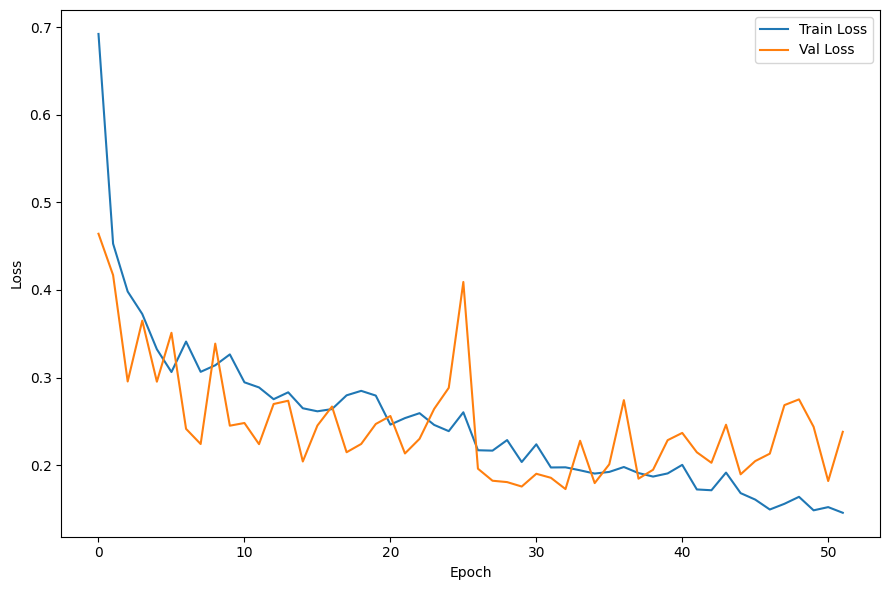

In [9]:
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')


# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(9, 6))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()



#system sleep for 2
time.sleep(2)
print(finetune_results_dir)
# Save the plot
plt.savefig(f'{finetune_results_dir}/loss_plot.png')

plt.show()

In [10]:
def validation_fun(modelpath,measure_checkpoint):
    import config
    # Set the device for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config.val_sound_length = 20
    # Create a data loader for the test set
    val_loader = DL.create_generators_finetune_val(val_df)  

    #model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
    model = torch.load(finetune_results_dir + modelpath)
    # Transfer the model to the testing device
    model.to(device)

    # Define a criterion for evaluation (e.g., cross-entropy loss for classification)
    criterion = nn.CrossEntropyLoss()

    # Initialize variables for evaluation metrics (e.g., accuracy)
    correct_predictions = 0
    total_samples = 0

    # Define the label dictionary
    true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

    # Set the model to evaluation mode 
    model.eval()

    # Initialize lists to store all true labels and predicted labels
    all_true_labels = []
    all_predicted_labels = []

    # Iterate through the test set
    with torch.no_grad():
        for spectrograms, labels in val_loader:
            # Move data to the testing device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            
            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Append true and predicted labels to the lists
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
    accuracy = np.mean(all_true_labels == all_predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='macro')


    #calculate balanced accuracy
    balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
    #kappa score
    cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


    print(f"\nEvaluation Results:")
    #print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
    print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"\nEvaluation Results:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1_score * 100:.2f}%")
    print(f"Kappa: {cohens_kappa * 100:.2f}%")

    conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
    def plot_confusion_matrix(conf_mat, class_labels):
        plt.figure(figsize=(7, 7))
        sns.set(font_scale=1.2)
        
        class_labels = [str(label) for label in class_labels]
        
        ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=class_labels,
                    yticklabels=class_labels)
        
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90)

        return plt.gcf()  # Return the current figure

    import config
    #create classification results text file
    with open(f'{finetune_results_dir}/results_file_{measure_checkpoint}.txt', 'w') as log_file:
        log_file.write(f"########################################################\n")
        log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
        log_file.write(f"Time Mask: {config.time_mask_param}\n")
        log_file.write(f"Spectro:\n")
        log_file.write(f"        n_fft={2048},\n")
        log_file.write(f"        hop_length = {512},\n")
        log_file.write(f"        n_mels={128},  \n")
        log_file.write(f"        win_length = {2048},\n")
        log_file.write(f"Epochs: {num_epochs}\n")
        log_file.write(f"Batch size: {batch_size}\n")
        log_file.write(f"Optimizer: Adam\n")
        log_file.write(f"Learning rate: {learning_rate}\n")
        log_file.write(f"Weight decay: {weight_decay}\n")
        log_file.write(f"Scheduler: ReduceLROnPlateau\n")
        log_file.write(f"Model: ModifiedResnet50_Classifier \n")
        log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
        log_file.write(f"########################################################\n\n")
        log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
        log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
        log_file.write(f"\nEvaluation Results:\n")
        log_file.write(f"Precision: {precision * 100:.2f}%\n")
        log_file.write(f"Recall: {recall * 100:.2f}%\n")
        log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
        log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
        log_file.write(f"########################################################\n\n")
        log_file.write(f"Confusion Matrix:\n")
        log_file.write(f"{conf_mat}\n")
        log_file.write(f"########################################################\n\n")
        log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values(),digits=4)}\n")

    print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values(),digits=4))

    #save this plot as a png file
    plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
    plot.savefig(f'{finetune_results_dir}/confusion_matrix_{measure_checkpoint}.png')








Evaluation Results:
Balanced Accuracy2: 93.85%
Test Accuracy: 93.86%

Evaluation Results:
Accuracy: 93.86%
Precision: 92.61%
Recall: 93.85%
F1-score: 93.12%
Kappa: 90.37%
                         precision    recall  f1-score   support

            [Kreischen]     0.9369    0.9455    0.9412       220
[Kreischen][Quietschen]     0.8519    0.9583    0.9020        72
              [Negativ]     0.9871    0.9217    0.9533       166
           [Quietschen]     0.9286    0.9286    0.9286        14

               accuracy                         0.9386       472
              macro avg     0.9261    0.9385    0.9312       472
           weighted avg     0.9414    0.9386    0.9391       472



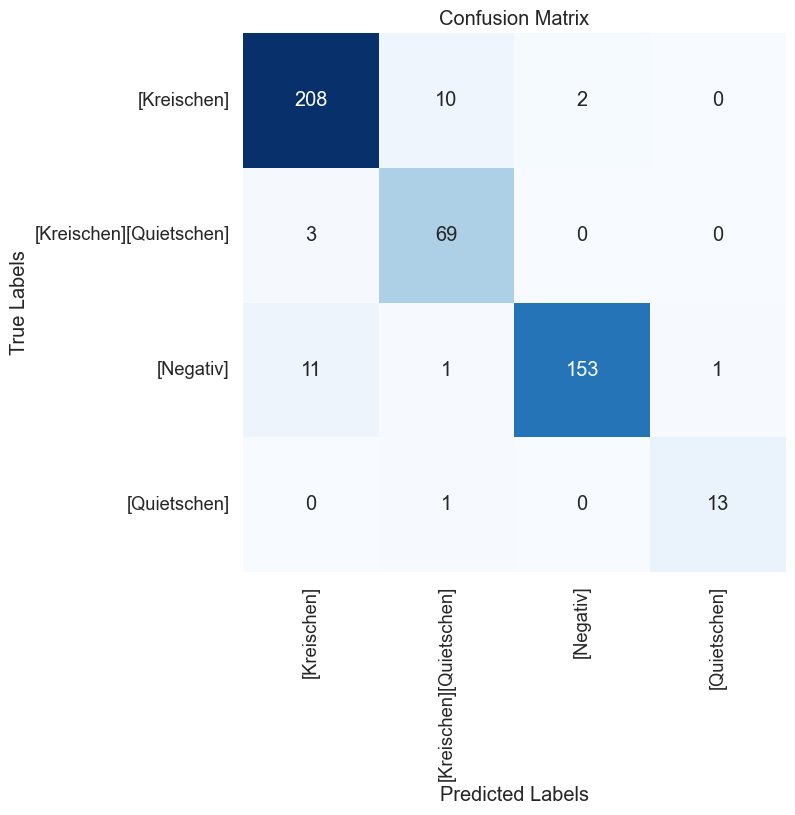

In [11]:
validation_fun('/Full_model_checkpoint.pth',"full_model")




Evaluation Results:
Balanced Accuracy2: 92.48%
Test Accuracy: 94.07%

Evaluation Results:
Accuracy: 94.07%
Precision: 95.41%
Recall: 92.48%
F1-score: 93.86%
Kappa: 90.58%
                         precision    recall  f1-score   support

            [Kreischen]     0.9217    0.9636    0.9422       220
[Kreischen][Quietschen]     0.9254    0.8611    0.8921        72
              [Negativ]     0.9691    0.9458    0.9573       166
           [Quietschen]     1.0000    0.9286    0.9630        14

               accuracy                         0.9407       472
              macro avg     0.9541    0.9248    0.9386       472
           weighted avg     0.9413    0.9407    0.9405       472



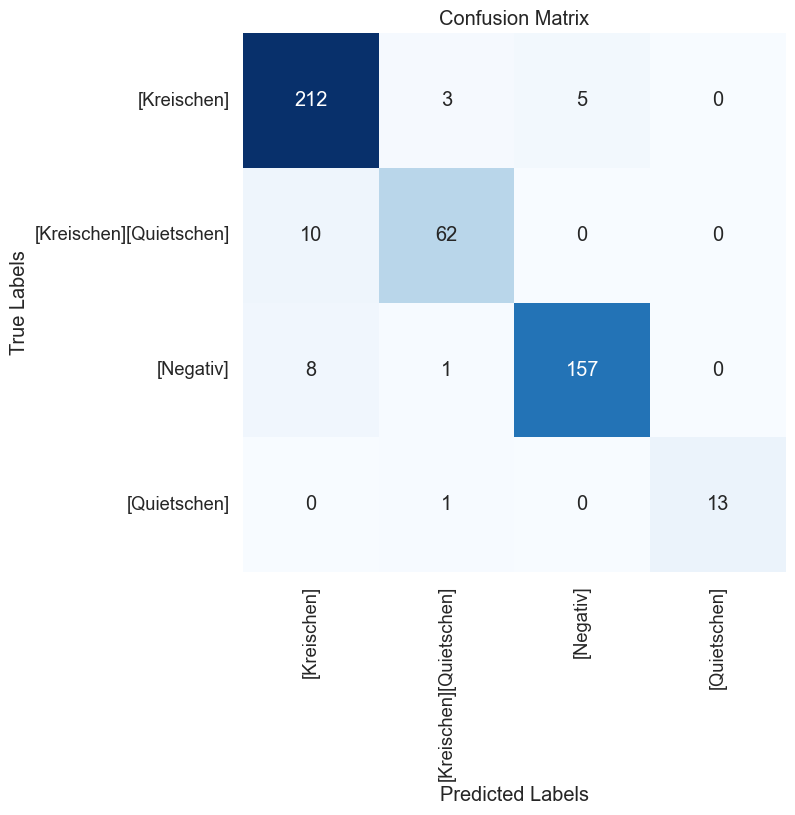

In [24]:
validation_fun('/checkpoint_best_f1.pth',"f1_model")





Evaluation Results:
Balanced Accuracy2: 91.98%
Test Accuracy: 93.64%

Evaluation Results:
Accuracy: 93.64%
Precision: 95.17%
Recall: 91.98%
F1-score: 93.48%
Kappa: 89.89%
                         precision    recall  f1-score   support

            [Kreischen]     0.9138    0.9636    0.9381       220
[Kreischen][Quietschen]     0.9242    0.8472    0.8841        72
              [Negativ]     0.9689    0.9398    0.9541       166
           [Quietschen]     1.0000    0.9286    0.9630        14

               accuracy                         0.9364       472
              macro avg     0.9517    0.9198    0.9348       472
           weighted avg     0.9373    0.9364    0.9362       472



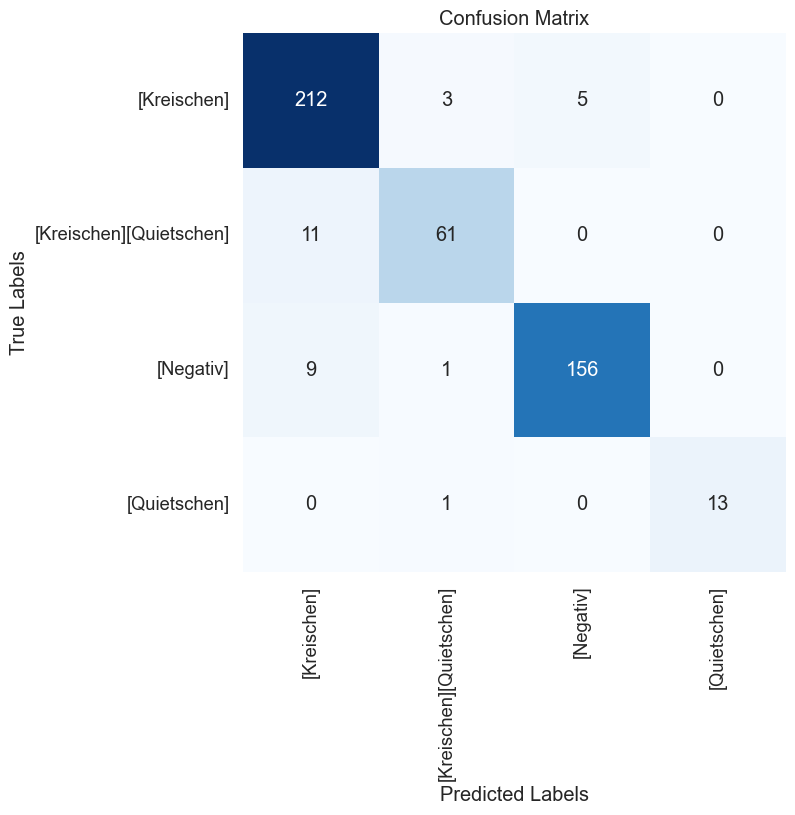

In [13]:
validation_fun('/checkpoint.pth',"best_accuracy")



Evaluation Results:
Balanced Accuracy2: 92.02%
Test Accuracy: 93.64%

Evaluation Results:
Accuracy: 93.64%
Precision: 95.12%
Recall: 92.02%
F1-score: 93.48%
Kappa: 89.90%
                         precision    recall  f1-score   support

            [Kreischen]     0.9174    0.9591    0.9378       220
[Kreischen][Quietschen]     0.9242    0.8472    0.8841        72
              [Negativ]     0.9632    0.9458    0.9544       166
           [Quietschen]     1.0000    0.9286    0.9630        14

               accuracy                         0.9364       472
              macro avg     0.9512    0.9202    0.9348       472
           weighted avg     0.9370    0.9364    0.9362       472



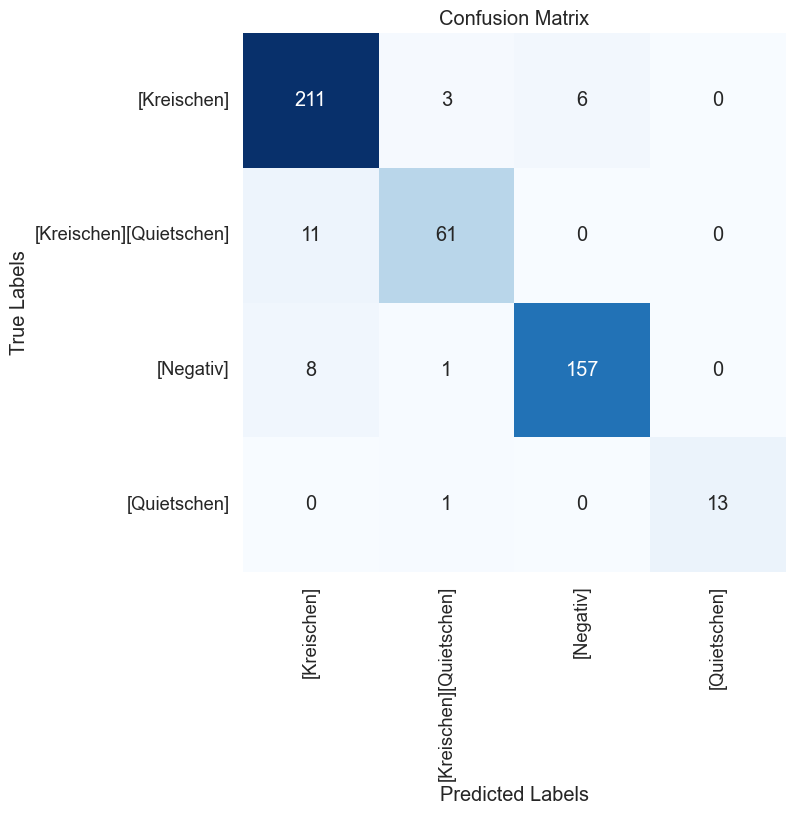

In [14]:
validation_fun('/checkpoint_best_loss.pth',"best_loss")

### Save Results of all 3 Modell Saves: Best-Val-Accuracy, Best-Val-loss and full model

In [15]:

# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
# from sklearn.metrics import cohen_kappa_score



# # Set the device for testing
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# #config.val_sound_length = 20

# # Create a data loader for the test set
# val_loader = DL.create_generators_finetune_val(val_df)  


# model = torch.load(finetune_results_dir + '/Full_model_checkpoint.pth')
# # Transfer the model to the testing device
# model.to(device)

# # Define a criterion for evaluation 
# criterion = nn.CrossEntropyLoss()

# # Initialize variables for evaluation metrics (e.g., accuracy)
# correct_predictions = 0
# total_samples = 0

# # Define the label dictionary
# true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# # Set the model to evaluation mode 
# model.eval()

# # Initialize lists to store all true labels and predicted labels
# all_true_labels = []
# all_predicted_labels = []

# # Iterate through the test set
# with torch.no_grad():
#     for spectrograms, labels in val_loader:
#         # Move data to the testing device
#         spectrograms = spectrograms.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(spectrograms)
        
#         # Compute the predicted labels
#         _, predicted = torch.max(outputs, 1)

#         # Append true and predicted labels to the lists
#         all_true_labels.extend(labels.cpu().numpy())
#         all_predicted_labels.extend(predicted.cpu().numpy())

# # Convert lists to numpy arrays
# all_true_labels = np.array(all_true_labels)
# all_predicted_labels = np.array(all_predicted_labels)

# # Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
# accuracy = np.mean(all_true_labels == all_predicted_labels)
# precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


# #calculate balanced accuracy
# balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
# #kappa score
# cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


# print(f"\nEvaluation Results:")
# #print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
# print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"\nEvaluation Results:")
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Precision: {precision * 100:.2f}%")
# print(f"Recall: {recall * 100:.2f}%")
# print(f"F1-score: {f1_score * 100:.2f}%")
# print(f"Kappa: {cohens_kappa * 100:.2f}%")

# conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
# def plot_confusion_matrix(conf_mat, class_labels):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)
    
#     class_labels = [str(label) for label in class_labels]
    
#     ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=class_labels,
#                 yticklabels=class_labels)
    
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.xticks(rotation=90)

#     return plt.gcf()  # Return the current figure

# #create classification results text file
# with open(f'{finetune_results_dir}/results_file_full.txt', 'w') as log_file:
#     log_file.write(f"########################################################\n")
#     log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
#     log_file.write(f"Time Mask: {config.time_mask_param}\n")
#     log_file.write(f"Random State:{randomstate} \n")
#     log_file.write(f"Spectro:\n")
#     log_file.write(f"        n_fft={2048},\n")
#     log_file.write(f"        hop_length = {512},\n")
#     log_file.write(f"        n_mels={128},  \n")
#     log_file.write(f"        win_length = {2048},\n")
#     log_file.write(f"Epochs: {num_epochs}\n")
#     log_file.write(f"Batch size: {batch_size}\n")
#     log_file.write(f"Optimizer: Adam\n")
#     log_file.write(f"Learning rate: {learning_rate}\n")
#     log_file.write(f"Weight decay: {weight_decay}\n")
#     log_file.write(f"Scheduler: ReduceLROnPlateau\n")
#     log_file.write(f"Model: ModifiedResnet50_Classifier \n")
#     log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
#     log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
#     log_file.write(f"\nEvaluation Results:\n")
#     log_file.write(f"Precision: {precision * 100:.2f}%\n")
#     log_file.write(f"Recall: {recall * 100:.2f}%\n")
#     log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
#     log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Confusion Matrix:\n")
#     log_file.write(f"{conf_mat}\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

# #save this plot as a png file
# print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

# plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
# plot.savefig(f'{finetune_results_dir}/confusion_matrix_full.png')









In [16]:

# # Create a data loader for the test set
# val_loader = DL.create_generators_finetune_val(val_df)  


# model = torch.load(finetune_results_dir + '/checkpoint.pth')
# #model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# # Transfer the model to the testing device
# model.to(device)

# # Define a criterion for evaluation 
# criterion = nn.CrossEntropyLoss()

# # Initialize variables for evaluation metrics (e.g., accuracy)
# correct_predictions = 0
# total_samples = 0

# # Define the label dictionary
# true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# # Set the model to evaluation mode 
# model.eval()

# # Initialize lists to store all true labels and predicted labels
# all_true_labels = []
# all_predicted_labels = []

# # Iterate through the test set
# with torch.no_grad():
#     for spectrograms, labels in val_loader:
#         # Move data to the testing device
#         spectrograms = spectrograms.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(spectrograms)
        
#         # Compute the predicted labels
#         _, predicted = torch.max(outputs, 1)

#         # Append true and predicted labels to the lists
#         all_true_labels.extend(labels.cpu().numpy())
#         all_predicted_labels.extend(predicted.cpu().numpy())

# # Convert lists to numpy arrays
# all_true_labels = np.array(all_true_labels)
# all_predicted_labels = np.array(all_predicted_labels)

# # Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
# accuracy = np.mean(all_true_labels == all_predicted_labels)
# precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


# #calculate balanced accuracy
# balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
# #kappa score
# cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


# print(f"\nEvaluation Results:")
# #print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
# print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"\nEvaluation Results:")
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Precision: {precision * 100:.2f}%")
# print(f"Recall: {recall * 100:.2f}%")
# print(f"F1-score: {f1_score * 100:.2f}%")
# print(f"Kappa: {cohens_kappa * 100:.2f}%")

# conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
# def plot_confusion_matrix(conf_mat, class_labels):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)
    
#     class_labels = [str(label) for label in class_labels]
    
#     ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=class_labels,
#                 yticklabels=class_labels)
    
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.xticks(rotation=90)

#     return plt.gcf()  # Return the current figure

# #create classification results text file
# with open(f'{finetune_results_dir}/results_file_best.txt', 'w') as log_file:
#     log_file.write(f"########################################################\n")
#     log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
#     log_file.write(f"Time Mask: {config.time_mask_param}\n")
#     log_file.write(f"Random State:{randomstate} \n")
#     log_file.write(f"Spectro:\n")
#     log_file.write(f"        n_fft={2048},\n")
#     log_file.write(f"        hop_length = {512},\n")
#     log_file.write(f"        n_mels={128},  \n")
#     log_file.write(f"        win_length = {2048},\n")
#     log_file.write(f"Epochs: {num_epochs}\n")
#     log_file.write(f"Batch size: {batch_size}\n")
#     log_file.write(f"Optimizer: Adam\n")
#     log_file.write(f"Learning rate: {learning_rate}\n")
#     log_file.write(f"Weight decay: {weight_decay}\n")
#     log_file.write(f"Scheduler: ReduceLROnPlateau\n")
#     log_file.write(f"Model: ModifiedResnet50_Classifier \n")
#     log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
#     log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
#     log_file.write(f"\nEvaluation Results:\n")
#     log_file.write(f"Precision: {precision * 100:.2f}%\n")
#     log_file.write(f"Recall: {recall * 100:.2f}%\n")
#     log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
#     log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Confusion Matrix:\n")
#     log_file.write(f"{conf_mat}\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

# print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

# #save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
# plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
# plot.savefig(f'{finetune_results_dir}/confusion_matrix_best.png')









In [17]:

# # Create a data loader for the test set
# val_loader = DL.create_generators_finetune_val(val_df)  

# randomstate = 96

# model = torch.load(finetune_results_dir + '/checkpoint_best_loss.pth')
# #model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# # Transfer the model to the testing device
# model.to(device)

# # Define a criterion for evaluation 
# criterion = nn.CrossEntropyLoss()

# # Initialize variables for evaluation metrics 
# correct_predictions = 0
# total_samples = 0

# # Define the label dictionary
# true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# # Set the model to evaluation mode 
# model.eval()

# # Initialize lists to store all true labels and predicted labels
# all_true_labels = []
# all_predicted_labels = []

# # Iterate through the test set
# with torch.no_grad():
#     for spectrograms, labels in val_loader:
#         # Move data to the testing device
#         spectrograms = spectrograms.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(spectrograms)
        
#         # Compute the predicted labels
#         _, predicted = torch.max(outputs, 1)

#         # Append true and predicted labels to the lists
#         all_true_labels.extend(labels.cpu().numpy())
#         all_predicted_labels.extend(predicted.cpu().numpy())

# # Convert lists to numpy arrays
# all_true_labels = np.array(all_true_labels)
# all_predicted_labels = np.array(all_predicted_labels)

# # Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
# accuracy = np.mean(all_true_labels == all_predicted_labels)
# precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


# #calculate balanced accuracy
# balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
# #kappa score
# cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


# print(f"\nEvaluation Results:")
# #print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
# print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"\nEvaluation Results:")
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"Precision: {precision * 100:.2f}%")
# print(f"Recall: {recall * 100:.2f}%")
# print(f"F1-score: {f1_score * 100:.2f}%")
# print(f"Kappa: {cohens_kappa * 100:.2f}%")

# conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
# def plot_confusion_matrix(conf_mat, class_labels):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)
    
#     class_labels = [str(label) for label in class_labels]
    
#     ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
#                 xticklabels=class_labels,
#                 yticklabels=class_labels)
    
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.xticks(rotation=90)

#     return plt.gcf()  # Return the current figure

# #create classification results text file
# with open(f'{finetune_results_dir}/results_file_best_loss.txt', 'w') as log_file:
#     log_file.write(f"########################################################\n")
#     log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
#     log_file.write(f"Time Mask: {config.time_mask_param}\n")
#     log_file.write(f"Random State:{randomstate} \n")
#     log_file.write(f"Spectro:\n")
#     log_file.write(f"        n_fft={2048},\n")
#     log_file.write(f"        hop_length = {512},\n")
#     log_file.write(f"        n_mels={128},  \n")
#     log_file.write(f"        win_length = {2048},\n")
#     log_file.write(f"Epochs: {num_epochs}\n")
#     log_file.write(f"Batch size: {batch_size}\n")
#     log_file.write(f"Optimizer: Adam\n")
#     log_file.write(f"Learning rate: {learning_rate}\n")
#     log_file.write(f"Weight decay: {weight_decay}\n")
#     log_file.write(f"Scheduler: ReduceLROnPlateau\n")
#     log_file.write(f"Model: ModifiedResnet50_Classifier \n")
#     log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
#     log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
#     log_file.write(f"\nEvaluation Results:\n")
#     log_file.write(f"Precision: {precision * 100:.2f}%\n")
#     log_file.write(f"Recall: {recall * 100:.2f}%\n")
#     log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
#     log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Confusion Matrix:\n")
#     log_file.write(f"{conf_mat}\n")
#     log_file.write(f"########################################################\n\n")
#     log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

# print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

# #save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
# plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
# plot.savefig(f'{finetune_results_dir}/confusion_matrix_best_loss.png')







